In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import joblib
from joblib import dump, load, parallel_backend, Parallel, delayed
import os
from datetime import datetime

In [2]:
# hàm save và load models
def save_models(svm_model, nb_model, ann_model, scaler, le, enc, base_dir='models'):
    """Lưu các models và preprocessors với timestamp"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    model_dir = os.path.join(base_dir, f'models_{timestamp}')
    os.makedirs(model_dir)
    
    joblib.dump(svm_model, os.path.join(model_dir, 'svm_model.joblib'))
    joblib.dump(nb_model, os.path.join(model_dir, 'nb_model.joblib'))
    joblib.dump(ann_model, os.path.join(model_dir, 'ann_model.joblib'))
    joblib.dump(scaler, os.path.join(model_dir, 'scaler.joblib'))
    joblib.dump(le, os.path.join(model_dir, 'label_encoder.joblib'))
    joblib.dump(enc, os.path.join(model_dir, 'onehot_encoder.joblib'))
    
    with open(os.path.join(model_dir, 'model_info.txt'), 'w') as f:
        f.write(f"Models saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("\nModel Structures:\n")
        f.write(f"SVM parameters: {str(svm_model.get_params())}\n")
        f.write(f"Naive Bayes parameters: {str(nb_model.get_params())}\n")
        f.write(f"Neural Network parameters: {str(ann_model.get_params())}\n")
    
    print(f"Models and preprocessors saved in: {model_dir}")
    return model_dir

def load_models(model_dir):
    """Load models và preprocessors từ thư mục đã lưu"""
    try:
        svm_model = joblib.load(os.path.join(model_dir, 'svm_model.joblib'))
        nb_model = joblib.load(os.path.join(model_dir, 'nb_model.joblib'))
        ann_model = joblib.load(os.path.join(model_dir, 'ann_model.joblib'))
        scaler = joblib.load(os.path.join(model_dir, 'scaler.joblib'))
        le = joblib.load(os.path.join(model_dir, 'label_encoder.joblib'))
        enc = joblib.load(os.path.join(model_dir, 'onehot_encoder.joblib'))
        
        return {
            'svm_model': svm_model,
            'nb_model': nb_model,
            'ann_model': ann_model,
            'scaler': scaler,
            'label_encoder': le,
            'onehot_encoder': enc
        }
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None

In [3]:
# Load data
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv('NSL_KDD_Train.csv', header=None, names=col_names)
df_test = pd.read_csv('NSL_KDD_Test.csv', header=None, names=col_names)

In [4]:
# Map attacks to their categories
attack_dict = {
    'normal': 'normal',
    'neptune': 'DoS', 'back': 'DoS', 'land': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L',
    'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
}

# Map categories to numeric values
df['label'] = df['label'].str.rstrip('.')
df['attack_category'] = df['label'].map(attack_dict)
df_test['attack_category'] = df_test['label'].map(attack_dict)

In [5]:
# Encode categorical features
categorical_columns = ['protocol_type', 'service', 'flag']
# One-hot encoding for categorical columns
enc = OneHotEncoder(sparse_output=False)
cat_enc = enc.fit_transform(df[categorical_columns])
cat_enc_test = enc.transform(df_test[categorical_columns])

In [6]:
# Get feature names after encoding
cat_cols = []
for i, col in enumerate(categorical_columns):
    cat_cols.extend([f"{col}_{val}" for val in enc.categories_[i]])

# Create new dataframes with encoded features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['label']]

In [7]:
X = np.hstack((df[numeric_cols].values, cat_enc))
X_test = np.hstack((df_test[numeric_cols].values, cat_enc_test))

In [9]:
# Let's first look at what categories we have
print("Unique categories in training set:", df['attack_category'].unique())
print("\nUnique categories in test set:", df_test['attack_category'].unique())


# Get all unique categories from both datasets
all_categories = set(df['attack_category'].unique()) | set(df_test['attack_category'].unique())
all_categories = all_categories - {np.nan}  # Remove nan if present

# Fill NaN values with the most common category from training set
most_common_category = df['attack_category'].mode()[0]
df['attack_category'] = df['attack_category'].fillna(most_common_category)
df_test['attack_category'] = df_test['attack_category'].fillna(most_common_category)

# Now proceed with label encoding
le = LabelEncoder()
# Fit the encoder on all possible categories
le.fit(list(all_categories))
# Transform both datasets
y = le.transform(df['attack_category'])
y_test = le.transform(df_test['attack_category'])

mask = df_test['attack_category'] != 'unknown'
df_test = df_test[mask]
X_test = X_test[mask]
y_test = y_test[mask]
mask_isna = ~df_test['attack_category'].isna()
df_test = df_test[mask_isna]
X_test = X_test[mask_isna]
y_test = y_test[mask_isna]
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

Unique categories in training set: ['normal' 'DoS' 'R2L' 'Probe' 'U2R']

Unique categories in test set: ['DoS' 'normal' 'Probe' 'R2L' 'U2R']


In [11]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models with optimized hyperparameters
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
nb_model = GaussianNB()
ann_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, 64, 32, 16),
    max_iter=1000,
    activation='relu',
    solver='adam',
    random_state=42,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.1
)

In [12]:
# Đầu tiên, kiểm tra các classes có trong dữ liệu
print("Unique classes in training data:", np.unique(y_train))
print("Unique classes in test data:", np.unique(y_test))

# Sau đó sửa lại hàm evaluate_model với đầy đủ tên các classes
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    
    # Train the model
    model.fit(X_train, y_train)
    
    
    # Make predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    
    print(f"\nCross-validation scores - {model_name}:")
    print(f"Mean: {cv_mean:.3f} (+/- {cv_std * 2:.3f})")
    
    # Confusion Matrix
    print(f"\nConfusion Matrix - {model_name}")
    print(confusion_matrix(y_test, y_test_pred))
    
    # Classification Report với đúng tên categories
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_test, y_test_pred, 
                            target_names=['normal', 'DoS', 'R2L', 'Probe', 'U2R']))
    
    # ROC Curve and AUC
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_test_pred_bin = label_binarize(y_test_pred, classes=np.unique(y_test))
    
    n_classes = y_test_bin.shape[1]
    class_names = ['normal', 'DoS', 'R2L', 'Probe', 'U2R']
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return cv_mean, cv_std

Unique classes in training data: [0 1 2 3 4]
Unique classes in test data: [0 1 2 3 4]



Evaluating SVM model...

Cross-validation scores - SVM:
Mean: 0.992 (+/- 0.001)

Confusion Matrix - SVM
[[6274   26    0    0 1158]
 [ 349 1706    3    0  363]
 [   0   10  271    0 1918]
 [   0   12    2   12   26]
 [ 408  304    3    8 9691]]

Classification Report - SVM
              precision    recall  f1-score   support

      normal       0.89      0.84      0.87      7458
         DoS       0.83      0.70      0.76      2421
         R2L       0.97      0.12      0.22      2199
       Probe       0.60      0.23      0.33        52
         U2R       0.74      0.93      0.82     10414

    accuracy                           0.80     22544
   macro avg       0.81      0.57      0.60     22544
weighted avg       0.82      0.80      0.77     22544



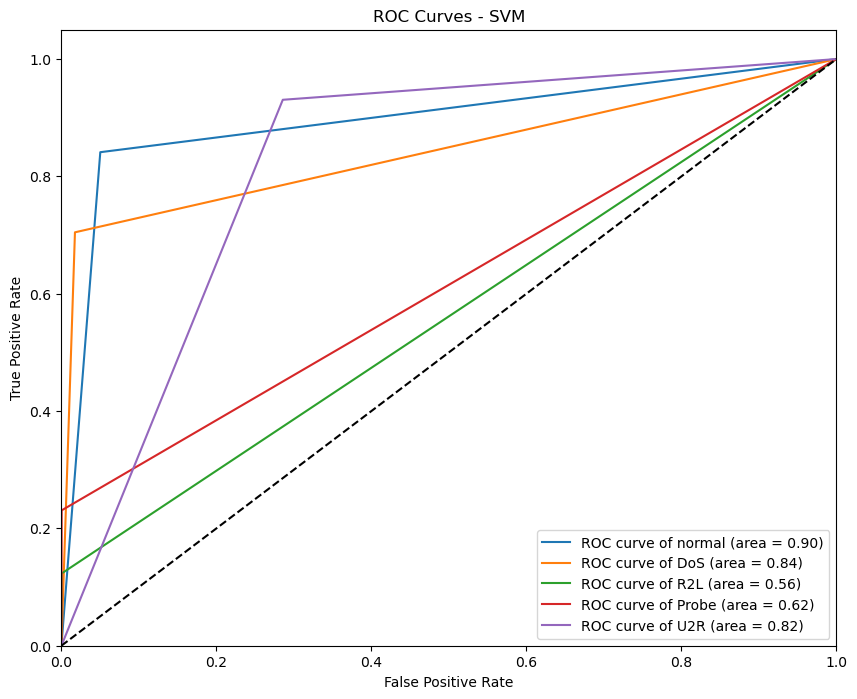


Evaluating Naive Bayes model...

Cross-validation scores - Naive Bayes:
Mean: 0.727 (+/- 0.152)

Confusion Matrix - Naive Bayes
[[2937    4 1172   29 3316]
 [ 348  195  338  131 1409]
 [   0    0  941  500  758]
 [   0    0   15   33    4]
 [  61   16 3137  326 6874]]

Classification Report - Naive Bayes
              precision    recall  f1-score   support

      normal       0.88      0.39      0.54      7458
         DoS       0.91      0.08      0.15      2421
         R2L       0.17      0.43      0.24      2199
       Probe       0.03      0.63      0.06        52
         U2R       0.56      0.66      0.60     10414

    accuracy                           0.49     22544
   macro avg       0.51      0.44      0.32     22544
weighted avg       0.66      0.49      0.50     22544



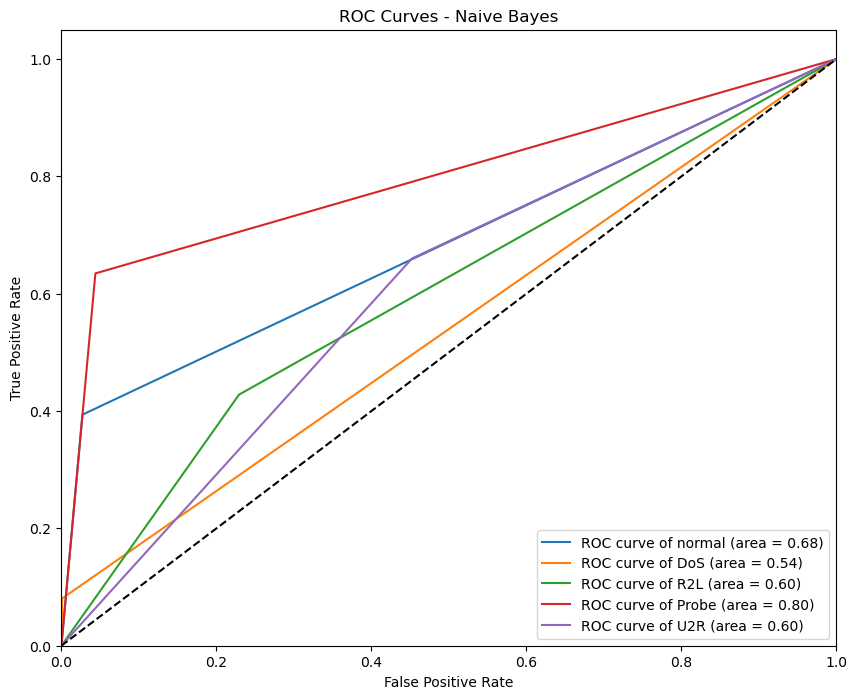


Evaluating Neural Network model...

Cross-validation scores - Neural Network:
Mean: 0.996 (+/- 0.001)

Confusion Matrix - Neural Network
[[ 6124    40     0     0  1294]
 [  200  1725    16    39   441]
 [    0     4   251     3  1941]
 [    0     0     2    24    26]
 [   56   254     3     8 10093]]

Classification Report - Neural Network
              precision    recall  f1-score   support

      normal       0.96      0.82      0.89      7458
         DoS       0.85      0.71      0.78      2421
         R2L       0.92      0.11      0.20      2199
       Probe       0.32      0.46      0.38        52
         U2R       0.73      0.97      0.83     10414

    accuracy                           0.81     22544
   macro avg       0.76      0.62      0.62     22544
weighted avg       0.84      0.81      0.78     22544



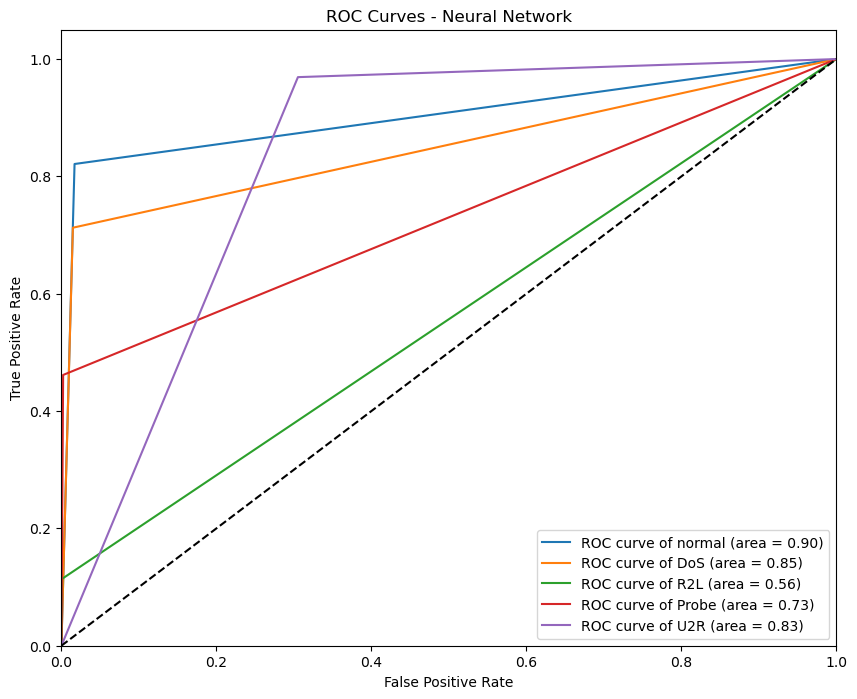

In [13]:
# Evaluate each model
print("\nEvaluating SVM model...")
svm_cv_mean, svm_cv_std = evaluate_model(svm_model, X_train, X_val, X_test_scaled, y_train, y_val, y_test, "SVM")

print("\nEvaluating Naive Bayes model...")
nb_cv_mean, nb_cv_std = evaluate_model(nb_model, X_train, X_val, X_test_scaled, y_train, y_val, y_test, "Naive Bayes")

print("\nEvaluating Neural Network model...")
ann_cv_mean, ann_cv_std = evaluate_model(ann_model, X_train, X_val, X_test_scaled, y_train, y_val, y_test, "Neural Network")

In [14]:
#Lưu models sau khi train xong
model_dir = save_models(
    svm_model=svm_model,
    nb_model=nb_model,
    ann_model=ann_model,
    scaler=scaler,
    le=le,
    enc=enc
)

Models and preprocessors saved in: models\models_20241201_230610


In [15]:
# Compare models
models_comparison = pd.DataFrame({
    'Model': ['SVM', 'Naive Bayes', 'Neural Network'],
    'CV Mean Accuracy': [svm_cv_mean, nb_cv_mean, ann_cv_mean],
    'CV Std': [svm_cv_std, nb_cv_std, ann_cv_std]
})

In [16]:
print("\nModel Comparison:")
print(models_comparison)


Model Comparison:
            Model  CV Mean Accuracy    CV Std
0             SVM          0.991516  0.000453
1     Naive Bayes          0.727153  0.075822
2  Neural Network          0.996329  0.000309


In [17]:
def display_models_summary(svm_cv_mean, svm_cv_std, nb_cv_mean, nb_cv_std, ann_cv_mean, ann_cv_std):
    """Hiển thị tổng kết về performance của các models"""
    
    print("=" * 50)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    
    # Format để hiển thị số float với 3 chữ số thập phân
    def format_metric(mean, std):
        return f"{mean:.3f} (+/- {std * 2:.3f})"
    
    # Tạo bảng so sánh
    print("\nCross-validation Scores:")
    print("-" * 50)
    print(f"SVM Model:          {format_metric(svm_cv_mean, svm_cv_std)}")
    print(f"Naive Bayes Model:  {format_metric(nb_cv_mean, nb_cv_std)}")
    print(f"Neural Network:     {format_metric(ann_cv_mean, ann_cv_std)}")
    print("-" * 50)
    
    # Xác định model tốt nhất
    models = {
        'SVM': svm_cv_mean,
        'Naive Bayes': nb_cv_mean,
        'Neural Network': ann_cv_mean
    }
    best_model = max(models.items(), key=lambda x: x[1])
    
    print(f"\nBest performing model: {best_model[0]} (CV Score: {best_model[1]:.3f})")
    
    # Hiển thị model parameters
    print("\nModel Configurations:")
    print("-" * 50)
    print("SVM Parameters:")
    for param, value in svm_model.get_params().items():
        print(f"  {param}: {value}")
    
    print("\nNaive Bayes Parameters:")
    for param, value in nb_model.get_params().items():
        print(f"  {param}: {value}")
    
    print("\nNeural Network Parameters:")
    for param, value in ann_model.get_params().items():
        print(f"  {param}: {value}")
    
    print("=" * 50)

# Sử dụng hàm để hiển thị summary
display_models_summary(
    svm_cv_mean, svm_cv_std,
    nb_cv_mean, nb_cv_std,
    ann_cv_mean, ann_cv_std
)

MODEL PERFORMANCE SUMMARY

Cross-validation Scores:
--------------------------------------------------
SVM Model:          0.992 (+/- 0.001)
Naive Bayes Model:  0.727 (+/- 0.152)
Neural Network:     0.996 (+/- 0.001)
--------------------------------------------------

Best performing model: Neural Network (CV Score: 0.996)

Model Configurations:
--------------------------------------------------
SVM Parameters:
  C: 1
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 0.0
  decision_function_shape: ovr
  degree: 3
  gamma: scale
  kernel: rbf
  max_iter: -1
  probability: True
  random_state: 42
  shrinking: True
  tol: 0.001
  verbose: False

Naive Bayes Parameters:
  priors: None
  var_smoothing: 1e-09

Neural Network Parameters:
  activation: relu
  alpha: 0.0001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: True
  epsilon: 1e-08
  hidden_layer_sizes: (512, 256, 128, 64, 32, 16)
  learning_rate: adaptive
  learning_rate_init: 0.001
  max_fun: 15

In [18]:
# Load models
loaded_models = load_models(model_dir)

if loaded_models is not None:
    print("Models loaded successfully!")
    # Test prediction với một số mẫu từ tập test
    X_sample = X_test[:5]  # Lấy 5 mẫu đầu tiên để test
    
    # Dự đoán với các models đã load
    svm_pred = loaded_models['svm_model'].predict(X_sample)
    nb_pred = loaded_models['nb_model'].predict(X_sample)
    ann_pred = loaded_models['ann_model'].predict(X_sample)
    
    # Chuyển đổi nhãn số về nhãn gốc
    svm_labels = loaded_models['label_encoder'].inverse_transform(svm_pred)
    nb_labels = loaded_models['label_encoder'].inverse_transform(nb_pred)
    ann_labels = loaded_models['label_encoder'].inverse_transform(ann_pred)
    
    print("\nPredictions for 5 samples:")
    print("SVM predictions:", svm_labels)
    print("Naive Bayes predictions:", nb_labels)
    print("Neural Network predictions:", ann_labels)

Models loaded successfully!

Predictions for 5 samples:
SVM predictions: ['Probe' 'Probe' 'Probe' 'Probe' 'Probe']
Naive Bayes predictions: ['Probe' 'Probe' 'Probe' 'Probe' 'Probe']
Neural Network predictions: ['DoS' 'DoS' 'Probe' 'normal' 'DoS']
